# Sports Analytics
By: Patrick Bulger, Tim Hulak, Jordan Hyatt, Cal Wardell

In [1]:
# Import Dependencies 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

In [2]:
# Read in data
NFL = pd.read_csv("NFLdata.csv", low_memory=False)

## Clean and Prep data

In [3]:
#Delete unneeded columns
col_del_list = [
  "no_score_prob","opp_fg_prob","opp_safety_prob","opp_td_prob","fg_prob",
  "safety_prob","td_prob","extra_point_prob","two_point_conversion_prob",
  "ep","epa","total_home_epa","total_away_epa","total_home_rush_epa",
  "total_away_rush_epa","total_home_pass_epa","air_epa","yac_epa","comp_air_epa",
  "comp_yac_epa","total_home_comp_air_epa","total_away_comp_air_epa",
  "total_home_comp_yac_epa","total_away_comp_yac_epa","total_home_raw_air_epa",
  "total_away_raw_air_epa","total_home_raw_yac_epa","total_away_raw_yac_epa", 
  "wp", "def_wp","home_wp","away_wp","wpa","home_wp_post","away_wp_post",
  "total_home_rush_wpa","total_away_rush_wpa","total_home_pass_wpa",
  "total_away_pass_wpa","air_wpa","yac_wpa","comp_air_wpa","comp_yac_wpa",
  "total_home_comp_air_wpa","total_away_comp_air_wpa","total_home_comp_yac_wpa",
  "total_home_raw_air_wpa","total_away_raw_air_wpa","total_home_raw_yac_wpa",
  "total_away_raw_yac_wpa","passer_player_id","receiver_player_id",
  "rusher_player_id","lateral_receiver_player_id","lateral_rusher_player_id",
  "lateral_sack_player_id","interception_player_id",
  "lateral_interception_player_id","punt_returner_player_id",
  "lateral_punt_returner_player_id","kickoff_returner_player_id",
  "lateral_kickoff_returner_player_id","punter_player_id","kicker_player_id",
  "own_kickoff_recovery_player_id","blocked_player_id",
  "tackle_for_loss_1_player_id","tackle_for_loss_2_player_id",
  "qb_hit_1_player_id","qb_hit_2_player_id","forced_fumble_player_1_player_id",
  "forced_fumble_player_2_player_id",
  "solo_tackle_1_player_id","solo_tackle_2_player_id","assist_tackle_1_player_id",
  "assist_tackle_2_player_id","assist_tackle_3_player_id",
  "assist_tackle_4_player_id","pass_defense_1_player_id","pass_defense_2_player_id",
  "fumbled_1_player_id","fumbled_2_player_id","fumble_recovery_1_team",
  "fumble_recovery_1_player_id","fumble_recovery_2_player_id","penalty_player_id",
  "total_away_pass_epa"
]

for column in col_del_list:
    del NFL[column]

__Fix Team Names__ <br> There are 32 NFL teams. The data spans from 2009 - 2018 and shows 35 unique teams. During that time frame, 3 NFL teams changed their team abbreviation. The Chargers moved from San Diego, CA to Los Angeles, CA in 2017, therefore their team abbreviation changed from SD to LAC. In 2013, a social media campaign and fan petition saw the Jaguars change their team abbreviation from JAC to JAX. Finally, in 2016 the Rams moved from St. Louis, MO to Los Angeles, CA and their team abbreviation changed from STL to LA. The first step in cleaning the data is to convert the old abbreviations to the new abbreviations in order to analyze team performance as a whole.

In [4]:
NFL.replace("JAC","JAX",inplace= True)
NFL.replace("SD","LAC",inplace= True)
NFL.replace("STL","LA",inplace= True)

In [5]:
#Add column to add season to data
def get_season(date):
    if type(date)==str: date = pd.to_datetime(date)
    year = date.year
    if date.month<5: year = year-1
    return f'season_{year}'
NFL['season'] = pd.to_datetime(NFL['game_date']).apply(get_season)
doc = open("Columns.txt",'w')
for column in NFL.columns:
    print(column, file = doc)
doc.close()

## Analytics

My role in this project was to answer the following two questions

__Question 1:What is the winning percentage for quarterback in games they throw over 40 times?__

C:\Users\calwa\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


There are 366 quaterbacks in our data


array([<AxesSubplot:title={'center':'pass_attempt'}, xlabel='Number of throws', ylabel='Number of games'>],
      dtype=object)

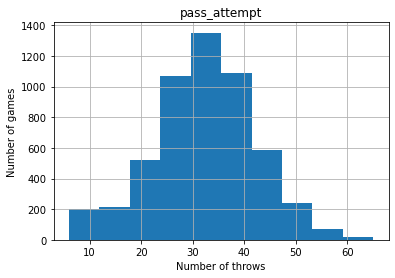

In [6]:
#Get columns needed from NFL Dataframe
passers = NFL[['game_id','home_team','away_team','posteam','defteam','passer_player_name','total_home_score'
               ,'total_away_score','posteam_score','defteam_score','pass_attempt','down','play_type','sack','complete_pass'
               ,'desc']]
#Remove duplicate plays
passers.drop_duplicates(subset=['desc'], inplace = True)
#Set up so passes are only counting when we have an actual pass attempt
passers = passers[passers['pass_attempt'] == 1]

passers = passers[passers['play_type'] == 'pass']

passers = passers[passers['sack'] == 0]
#To get the total number of quaterbacks in the data
print(f"There are {len(passers['passer_player_name'].unique())} quaterbacks in our data")
#Make a datafame that is grouped by games and players and counts pass attempts

#asser_group = passers.groupby(['game_id','game_date','passer_player_name','posteam','defteam'], as_index = False).pass_attempt.sum().reset_index()
passer_group = passers.groupby(['game_id','passer_player_name','posteam'], as_index = False).pass_attempt.sum().reset_index()
#Delete extra column
del passer_group['index']
#histogram of our data 
passer_hist_df = passer_group.loc[passer_group['pass_attempt'] > 5]
passer_hist = passer_hist_df.hist('pass_attempt')
ax = passer_hist[0]
for x in ax:
    x.set_xlabel('Number of throws')
    x.set_ylabel('Number of games')
ax

Majority of games the quarterback throws between 20 and 40 times. 

In [7]:
#Function that gets us the winner of each game
def get_winner(df):
    max_hs = df.total_home_score.max() #max score of home team for each game
    max_as = df.total_away_score.max() #max score for away team in each game
    if max_hs > max_as:
        return df.home_team.iloc[0] #If home team has more points by end of game return home team
    else:
        return df.away_team.iloc[0] # If away team has more points by end of tame return away team

winners = passers.groupby('game_id').apply(get_winner) #run function
winners.name = 'winning_team' #assign value
#join winning team to each game, match by game_id
gdf=passer_group.set_index('game_id').join(winners)


In [19]:
#function returns true if the possesion team is equal to winning team and False if not
def get_won(ser):
    if ser.posteam == ser.winning_team:
        return True
    else:
        return False
gdf['won']=gdf.apply(get_won,axis=1) #Apply function
gdf.head()

,passer_player_name,posteam,pass_attempt,winning_team,won,overlimit,win_with_40
game_id,,,,,,,
2009091000,B.Roethlisberger,PIT,43.0,TEN,False,True,False
2009091000,K.Collins,TEN,35.0,TEN,True,False,False
2009091300,C.Pennington,MIA,28.0,ATL,False,False,False
2009091300,M.Ryan,ATL,36.0,ATL,True,False,False
2009091300,P.White,MIA,1.0,ATL,False,False,False


In [9]:
#Returns a column with ture if pass attempts by the quarterback is equal to or over the 40 we are looking at
gdf['overlimit']=gdf.pass_attempt >= 40
#Function that will return true if the quaterback throw over 40 times and won the game, false for any other situation
def win_with_40 (ser):
    if ser.won == True and ser.overlimit == True:
        return True
    else:
        return False
gdf['win_with_40'] = gdf.apply(win_with_40, axis = 1) # apply function

In [10]:
#Returns the total percentage of games that the quaterback threw over 40 and won the game.
gdf['win_with_40'].value_counts(normalize=True).mul(100).astype(str)+'%'

False    94.14884800265209%
True      5.85115199734792%
Name: win_with_40, dtype: object

Overall, only about 6% of games the quaterback wins when he throws over 40 times. Now to look at each quaterback and see if any quaterbacks have a winning record

In [11]:
#Data frame with the needed info to do our anlysis 
Win = gdf[['passer_player_name','overlimit','win_with_40']]
Win = Win.loc[Win['overlimit'] == True] #Remove instance a QB didnt throw the ball over 40 times

In [12]:
#Gets the winning percetage of games where he threw over 40 for each quaterback 
WinPerc = Win.groupby('passer_player_name')
WinPerc = WinPerc['win_with_40'].value_counts(normalize = True)
WinPerc = WinPerc.drop(labels=False, level =1)
WinPerc.name ="WinPerc"

In [13]:
#Gets the total number of games won where he threw over 40 for each quaterback
WinCount = Win.groupby('passer_player_name')
WinCount = WinCount['win_with_40'].value_counts()
WinCount = WinCount.drop(labels=False, level =1)
WinCount.name = "WinCount"

In [14]:
#Data frame that is sorted with best winning percentags and then the number of games won throwing over 40 times
Winning = pd.concat([WinPerc,WinCount], axis = 1)
Winning = Winning.sort_values(by=['WinPerc','WinCount'], ascending = False)
Winning['NumofGames'] = Winning['WinCount']/Winning['WinPerc'] #Calculate the number of games that the quaterback threw 40+ times
Winning[Winning['NumofGames'] > 10] #just look at quaterbacks who have 5 or more wins 
#Winning['WinPerc'].mean() #average winning percentage 

,,WinPerc,WinCount,NumofGames
passer_player_name,win_with_40,,,
T.Brady,True,0.680851,32,47.0
P.Manning,True,0.675000,27,40.0
M.Schaub,True,0.500000,7,14.0
A.Rodgers,True,0.452381,19,42.0
D.Brees,True,0.428571,30,70.0
A.Luck,True,0.400000,14,35.0
P.Rivers,True,0.365854,15,41.0
B.Roethlisberger,True,0.363636,16,44.0
A.Dalton,True,0.346154,9,26.0


__Summary__

With only two quarterbacks with winning percentages in games where they throw over 40 times, we would not recommend increasing the number of throws per games. 

__Question 2: What leads to more points, runs or throws?__

In [20]:
#First get max score for each team for each game
pos_team_score = NFL[['game_id','posteam','posteam_score']]
pos_team_score = pos_team_score.groupby(['game_id','posteam']).max().reset_index()
#Count the number of runs
num_runs = NFL[['game_id','posteam','run_location']]
num_runs = num_runs.groupby(['game_id','posteam']).count().reset_index()
#Count the number of runs
num_throws = NFL[['game_id','posteam','pass_location']]
num_throws = num_throws.groupby(['game_id','posteam']).count().reset_index()
run_v_throw = pd.merge(pos_team_score, num_runs, how = 'inner',
                       left_on = ['game_id','posteam'], right_on = ['game_id','posteam'])
run_v_throw = pd.merge(run_v_throw, num_throws, how = 'inner',
                       left_on = ['game_id','posteam'], right_on = ['game_id','posteam'])
run_v_throw = run_v_throw.rename(columns = {'run_location':'num_runs', 'pass_location':'num_throws'})
run_v_throw['throws_over_run'] = (run_v_throw['num_throws'] - run_v_throw['num_runs'])/(run_v_throw['num_throws'] + run_v_throw['num_runs'])
#Normalize the data
run_v_throw['normal_posteam_score'] = (run_v_throw['posteam_score']  - run_v_throw['posteam_score'].mean())/run_v_throw['posteam_score'].std()
#run_v_throw['normal_throws_over_run'] = (run_v_throw['throws_over_run']  - run_v_throw['throws_over_run'].mean())/run_v_throw['throws_over_run'].std()
run_v_throw.head()

,game_id,posteam,posteam_score,num_runs,num_throws,throws_over_run,normal_posteam_score
0,2009091000,PIT,10.0,23,43,0.303030,-1.185815
1,2009091000,TEN,10.0,25,35,0.166667,-1.185815
2,2009091300,ATL,19.0,24,36,0.200000,-0.288207
3,2009091300,MIA,6.0,22,30,0.153846,-1.584752
4,2009091301,BAL,37.0,41,43,0.023810,1.507009


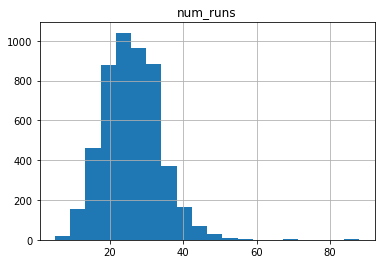

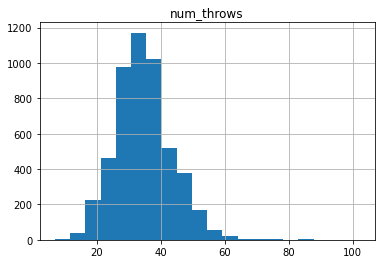

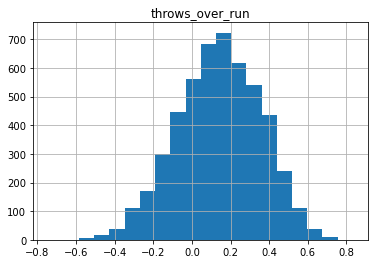

In [16]:
#Visualize data
run_v_throw.hist('num_runs', bins = 20)
run_v_throw.hist('num_throws', bins = 20)
run_v_throw.hist('throws_over_run', bins = 20)
plt.show()

From the histograms above, most games have slightly more throws then runs. Below is the linear regression of the number of throws over runs and the score of the team to see if throwing or running more leads to more points. 

<function matplotlib.pyplot.show(close=None, block=None)>

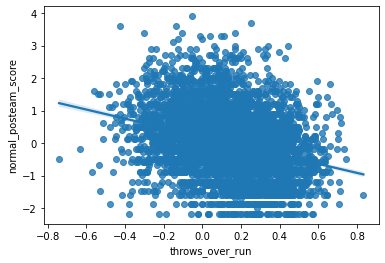

In [17]:
ax = sns.regplot(x='throws_over_run', y='normal_posteam_score', data=run_v_throw)
plt.show

In [18]:
#Do a ordinarly least square regression on the data
result = sm.ols(formula = "normal_posteam_score ~ throws_over_run", data = run_v_throw).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     normal_posteam_score   R-squared:                       0.091
Model:                              OLS   Adj. R-squared:                  0.091
Method:                   Least Squares   F-statistic:                     507.0
Date:                  Mon, 09 May 2022   Prob (F-statistic):          4.62e-107
Time:                          19:50:34   Log-Likelihood:                -6926.3
No. Observations:                  5052   AIC:                         1.386e+04
Df Residuals:                      5050   BIC:                         1.387e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1956      0.016     12.240      0.000       0.164       0.227
throws_over_run    -1.3922      0.062    -22.516      0.000      -1.513      -1.271
==============================================================================
Omnibus:                       81.960   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.033
Skew:                           0.306   Prob(JB):                     2.08e-19
Kurtosis:                       3.186   Cond. No.                         4.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our plot shows there is trend that running the ball leads to more points. From the summary of the ordinary least square regression, the p-value is well below the 0.05 so its statistically significant. However, the R-Square is 0.091. So only 9% of the change in score is due to the number of throws over run. Not enough to recommend a full focus of only the run game verses the teams throwing game. But there is some correlation so our recommendation is to focus on building a strong run game if a team is in the process of a rebuild. 